### <h1 style="text-align:center">ASI   </h1>
<h2 style="text-align:center">Naïve Bayes Classifier and Bayesian Linear Regression</h2>
<h3 style="text-align:center">Matteo Fiore</h3>

In [1]:
from utils import MNIST
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
import functools
import pickle
import time
classes = [0,1,2,3,4,5,6,7,8,9]

<div style="background-color:#327191; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h1><font color='white'>Load Datasets</font></h1>
</div>

#### CIFAR10

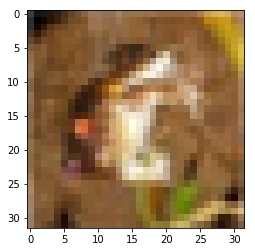

label of image is --> 6


In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

base_cfar10 = 'cifar-10-batches-py/'
cfar10_files = ['data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5']

data_cfar10 = []
for f in cfar10_files:
    data_cfar10.append(unpickle(base_cfar10+f))
cfar10_test = unpickle(base_cfar10+'test_batch')

cfar10_meta = unpickle(base_cfar10+'batches.meta')

cfar10_training_images = np.array([d[b'data'] for d in data_cfar10]).flatten().reshape(50000,3072)
cfar10_training_labels = np.array([d[b'labels'] for d in data_cfar10]).flatten()
cfar10_test_images = cfar10_test[b'data']
cfar10_test_labels = np.array(cfar10_test[b'labels'])

# example 
im = np.reshape(cfar10_training_images[0], (32,32,3), order='F')
plt.imshow(im)
plt.show()
print('label of image is --> '+str(cfar10_training_labels[0]))

#### MNIST

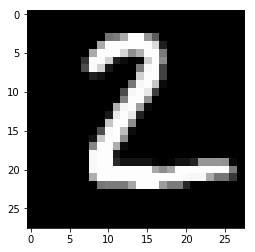

label of image is --> 2


In [3]:
mndata = MNIST('.',return_type='numpy')
mnist_training_images, mnist_training_labels = mndata.load_training()
mnist_testing_images, mnist_testing_labels = mndata.load_testing()

# example of data
im = np.reshape(mnist_testing_images[1], (28,28))
plt.imshow(im, cmap='gray')
plt.show()
print('label of image is --> '+str(mnist_testing_labels[1]))

<div style="background-color:#327191; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h1><font color='white'>Comment on dimensionality and distribution of classes</font></h1>
</div>

<div style="background-color:#d9e6fc; padding:15px 15px 15px 15px;"> 
The classes' distribution can affect the classification, since if the prior for class A is a lot greater than prior of the other classes, the product <i>likelihood*prior</i> will be also greater (supposing the likelihood is not varying too much from one class to another) and will "attract" more data.<br><br>
Focusing on the dimensionality, the highest the dimensionality, the highest the number of combination of the features. If there are too many features but not enough data, it is not possible to have a sufficient number of data for each possible combination of features. This results in overfitting: we are creating a model using a set of data that describes only a part of the total dataset, that correspond to not being able to caracterize all the dataset corresponding to all the possible features.  
  
Below there is a plot showing the distribution of the elements per class: in the MNIST dataset it is possible to notice a greater variance in the distribution.
</div>

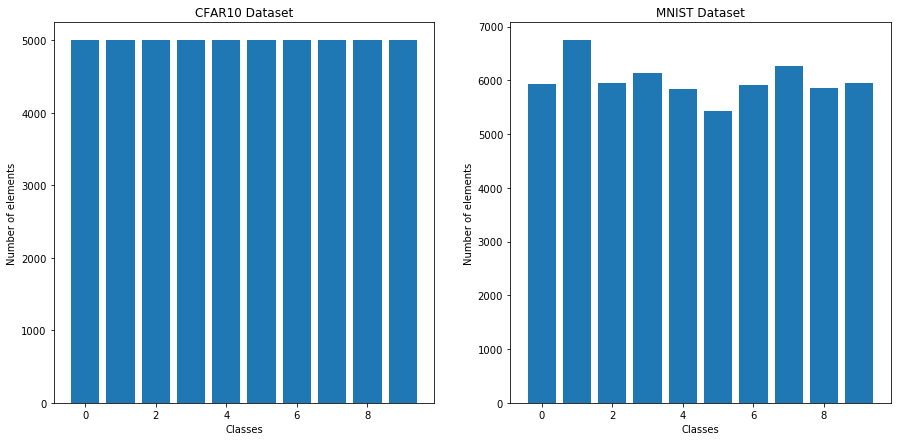

In [6]:
plt.figure(figsize=(15,7))
plt.subplot(121)


plt.bar(range(0,10),[len(cfar10_training_labels[cfar10_training_labels==c]) for c in range(0,10)])
plt.title('CFAR10 Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of elements')

plt.subplot(122)

plt.bar(range(0,10),[len(mnist_training_labels[mnist_training_labels==c]) for c in range(0,10)])
plt.title('MNIST Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of elements')

plt.show()



<div style="background-color:#327191; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h1><font color='white'>Data Cleaning</font></h1>
</div>

<div style="background-color:#d9e6fc; padding:15px 15px 15px 15px;"> 
Before operating on the data, it could be useful to identify eventual outliers. Proceding in this way can possibly lead to a better solution later on. The procedure is the following:
<ul>
<li> for each class calculate the mean 
<li> calculate the average distance and the standard deviation of the distances for each class
<li> eliminate the images which distance from the mean is not in the interval <i>[average_distance - standard_dev,average_distance + standard_dev]</i>
</ul>

</div>

In [ ]:

avg_dist_for_class = []
std_for_class = []
imgs_mean = []

# for each class calculate the mean amd
# calculate the average distance and the standard deviation of the distances 
for c in classes:
    cls_img = mnist_training_images[mnist_training_labels==c]
    img_mean = np.mean(cls_img,axis=0)
    distances = [np.linalg.norm(img_mean-e) for e in cls_img]
    std_for_class.append(np.std(distances))
    avg_dist_for_class.append(np.mean(distances))
    imgs_mean.append(img_mean)

# eliminate the images which distance from the mean is not
# in the interval [average_distance - standard_dev,average_distance + standard_dev]
mask = []
for e,lbl in zip(mnist_training_images,mnist_training_labels):
    dist = np.linalg.norm(imgs_mean[lbl]-e)
    if dist > avg_dist_for_class[lbl] + std_for_class[lbl] or \
            dist < avg_dist_for_class[lbl] - std_for_class[lbl]:
        mask.append(False)
    else:
        mask.append(True)
mask = np.array(mask)    
filter_mnist_training_images=mnist_training_images[mask]
filter_mnist_training_labels=mnist_training_labels[mask]


plt.figure(figsize=(15,5))
plt.bar(range(0,10),[len(filter_mnist_training_images[filter_mnist_training_labels==c]) for c in range(0,10)])
plt.title('MNIST Dataset filtered')
plt.xlabel('Classes')
plt.ylabel('Number of elements')
plt.show()

print('Number of elements after filtering --->',len(filter_mnist_training_images))

<div style="background-color:#d9e6fc; padding:15px 15px 15px 15px;"> 
From the graph above it is possible to notice that the classes are still not balanced. We are now balancing these classes, setting a number of images for each of them equal to 3500.

</div>

In [ ]:
batch_dim = 3500
num_classes = 10
img_dim = 784
new_mnist_training_images = np.array(functools.reduce(lambda x,y: np.append(x,y),
                              [filter_mnist_training_images[filter_mnist_training_labels==c][:batch_dim] 
                               for c in range(0,10)])).reshape(batch_dim*num_classes,img_dim)
new_mnist_training_labels = []
for c in classes:
    new_mnist_training_labels+=[c]*batch_dim
len(new_mnist_training_labels)
new_mnist_training_labels = np.array(new_mnist_training_labels)

plt.figure(figsize=(15,5))
plt.bar(range(0,10),[len(new_mnist_training_images[new_mnist_training_labels==c]) for c in range(0,10)])
plt.title('MNIST Dataset filtered and balanced')
plt.xlabel('Classes')
plt.ylabel('Number of elements')
plt.show()

<div style="background-color:#327191; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h1><font color='white'>Naïve Bayes</font></h1>
</div>

<div style="background-color:#d9e6fc; padding:15px 15px 15px 15px;"> 
<h3>Pros and Cons</h3>
<br>
It is possible to identify pros and cons of using this kind of classifier (Naive Bayes). A NB classifier is a simple classifier, and it is also very fast to converge if the assumption of independence holds. If it doesn't hold this method still allows to arrive to a good solution, but not the best one. On the other hand, if data are skewed, that means more training examples for one class than another, it can cause the decision boundaries to be biased. This cause the classifier to unwillingly prefer one class over the other. A similar trend can be seen when the indipendence costraint is not respected: the likelihood tend to be greater for classes that most violate the indipendence assumption.


</div>

<div style="background-color:#d9e6fc; padding:15px 15px 15px 15px;"> 
<h3>Our Classifier</h3>
<br>

Our classifier consist in a python class able to calculate the mean and variance of the training data, in order to calculate the likelihood of the new data needed to be evaluated. In particular we used the probability density function in order to calculate the "probability", and not the actual probability calculated as the integral of the function. This because with the actual probability, the highest the value with respect to the mean, the highest is going to be the probability. In our case we want the values closest to the mean to have more impact, that's why the use of the pdf.<br><br>

When the likelihood is computed, since we are implementing a naive method, we can consider the different probabilities of the different features as indipendent, and simply multiply them with one another. A common problem is to end up with a very small number at the end, since we are multiplying numbers that are less than 1.<br>
A solution could be to use the logarithm, and since the logarithm of a multiplication is the sum of the log of each element, that is what is computed instead of the multiplication. One fact to keep in mind is the following: the log of a probability is less than 0, since the probability is less than 1. When we calculate the likelihood we obtain something less than 0 that is going to be divided by something that is also less than zero (<i>sum over all the classes of likelihood*prior</i>). The numerator is going to be smaller and smaller as the likelihood is moving from a value of 1 to 0: so we obtain something less than 0 and very small. When this result is divided by something also less than 0 is going to be a big positive number. <br>

<h4>What we obtain?</h4> <br>
The smaller the likelihood, the smaller the log of it, but at the end is going to be very big. At the end we are not looking for the max value, we are rather looking for the smallest one thanks to this inversion of sign.

<h4>Log-Likelihood tuning</h4>
<br>
Sometimes it is possible that the log of the likelihood is -inf: this is due to a too small value of the likelihood. A part of data cleaning could be getting rid of -inf values, that during the sum of the logs will wrongly influenciate the result.



</div>

In [7]:
class Evaluate:
    def __init__(self,classes,training_data,training_labels,test_data,test_labels):
        self.classes = classes
        self.training_data = training_data
        self.training_labels = training_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.mu = []
        self.sigma2 = []
        self.priors = np.array([])
        self.predictions = np.array([])
    
    def mean_and_var(self):
        for c in self.classes:
            imgs = self.training_data[self.training_labels == c]
            var = np.std(imgs,axis=0, ddof=1)
            mn = np.mean(imgs,axis=0)
            self.mu.append(mn)
            self.sigma2.append(var)
        self.mu = np.array(self.mu)
        self.sigma2 = np.array(self.sigma2)

        
    def gaussian(self, x, m, v):
        return 1 / np.sqrt(2 * np.pi * v) * np.exp(-(x - m)**2 / (2 * v))
    
    def likelihood(self, cls, data):
        log_prob = np.array([np.log(self.gaussian(d, m, v)) if v > 0.0 else 0 for 
                         m, v, d in zip(self.mu[cls], self.sigma2[cls], data)])
        mn = min(log_prob[log_prob!=-math.inf])
        return sum(                
                  [d if d != -math.inf else mn-1 for d in log_prob]  
               )
    
    def prior(self):
        pr = []
        for c in self.classes:
            mask = self.training_labels == c
            pr.append(len(self.training_data[mask]))
        self.priors =  np.array([e/sum(pr) for e in pr])
        
    
    def predict(self):
        labels = []
        for d_test_img, d_test_lbl in zip(self.test_data,self.test_labels):            
            probs = []
            for c in self.classes:           
                probs.append(self.likelihood(c,d_test_img)*self.priors[c])                
            s = np.sum(probs)
            probs = [p/s for p in probs]
            labels.append(probs.index(min(probs)))
        self.predictions = np.array(labels)        
                
    
    def accuracy(self):
        err = ok = 0
        for pred, eff in zip(self.predictions, self.test_labels):
            if pred == eff:
                ok = ok + 1
            else:
                err = err + 1
        return (ok,err)


<div style="background-color:#5a8da7; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'>Evaluation of Naive Bayes with MNIST training and test set</font></h3>
</div>

In [6]:
classes = [0,1,2,3,4,5,6,7,8,9]
ev = Evaluate(classes,mnist_training_images,mnist_training_labels,mnist_testing_images,mnist_testing_labels)
ev.prior()
ev.mean_and_var()
ev.predict()

/home/nomet/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log


In [7]:
# ev.predict()
accuracy = ev.accuracy()[0]/(ev.accuracy()[0]+ev.accuracy()[1])
print("accuracy -->",accuracy,"with",ev.accuracy()[0],"good classifications and",ev.accuracy()[1],"wrong classifications")

accuracy --> 0.8159 with 8159 good classifications and 1841 wrong classifications


In [8]:
# save for eventual future use
f = open('prediction_mnist','wb')
pickle.dump(ev.predictions,f)

<div style="background-color:#5a8da7; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'>Evaluation of Naive Bayes with CFAR training and test set</font></h3>
</div>

In [14]:
classes = [0,1,2,3,4,5,6,7,8,9]
ev_cfar10 = Evaluate(classes,cfar10_training_images,cfar10_training_labels,cfar10_test_images,cfar10_test_labels)
ev_cfar10.prior()
ev_cfar10.mean_and_var()
ev_cfar10.predict()

In [15]:
accuracy = ev_cfar10.accuracy()[0]/(ev_cfar10.accuracy()[0]+ev_cfar10.accuracy()[1])
print("accuracy -->",accuracy,"with",ev_cfar10.accuracy()[0],
      "good classifications and",ev_cfar10.accuracy()[1],"wrong classifications")

accuracy --> 0.2722 with 2722 good classifications and 7278 wrong classifications


In [16]:
f = open('prediction_mnist','wb')
pickle.dump(ev_cfar10.predictions,f)

<div style="background-color:#5a8da7; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'>Performance discussion</font></h3>
</div>

<div style="background-color:#d9e6fc; padding:15px 15px 15px 15px;"> 
We can see how the Naive Bayes classifier used on to make predictions on the mnist dataset performs quite good, with an accuracy of 81.59 percent, while on the cfar dataset the performances are not that good, only 27.22 percent. The reason could be that in the cfar dataset are present images more complicated and with number of colors greater than mnist images. This increase in features could have lead to a more difficult understanding of the image and to a higher misclassification rate.
</div>

<div style="background-color:#5a8da7; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'>Confusion Matrix</font></h3>
</div>

#### MNIST data set

In [11]:
predictions = pickle.load(open('prediction_mnist','rb'))
matrix = []
for c in classes:
    mask = mnist_testing_labels == c
    class_pred = predictions[mask]
    matrix.append([len(class_pred[class_pred == c]) for c in classes])

In [12]:
from tabulate import tabulate
print(tabulate(np.c_[range(10),matrix], headers=['Classes']+classes))


  Classes    0    1    2    3    4    5    6    7    8    9
---------  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---
        0  885    0    2    0    0   75    9    1    8    0
        1    0  938   20    1    1   84    6    0   85    0
        2   18    1  881    8    8   27   24    7   57    1
        3    8    0   49  695    2  181    5    2   57   11
        4    3    0    9    0  796   49   19    0   30   76
        5    9    0    6   17    8  820   11    0   15    6
        6   24    2   16    0   13   75  824    0    4    0
        7   10    8   35    0   23   42    0  764   59   87
        8    7    0   17   13    6  142    7    3  760   19
        9   14    1    4    1   91   57    1    4   40  796


<div style="background-color:#327191; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h1><font color='white'>Bayesian Linear Regression</font></h1>
</div>

<div style="background-color:#d9e6fc; padding:15px 15px 15px 15px;"> 
The class below is used to create the bayesian linear regression method that will allow us to predict the type of an image using linear regression. Before being able to operate on the data, it is necessary to modify their structure, without changin the meaning and the content of each image. We defined the prior over w (<i>p(w)</i>) as a diagonal matrix with the element's value equal to 10000. 
<br>
<h3>Problems encountered and solution proposed</h3>
<br>
We are working with discrete variables, but linear regression works with continues variables. In order to solve this problem we decided to treat each label as a one-hot vector. In this way we will not obtain a vector of weights of dimension <i>K+1</i> (where K is the grade of the polynomial and the + 1 is the grade zero term), but a matrix of dimension <i>K+1 x number_different_classes</i>. At the end of the prediction phase, for each test image not a single class will be returned but a set of N predictinos, where N is the number of different classes. Picking the highest value will give us the (hopefully) correct prediction.
</div>

In [5]:
class BLR():
    def __init__(self, classes, training_data, training_labels, test_data,test_labels, sigma, binary=True):     
        # rapresent each class as a one-hot vector
        self.classes = np.eye(len(classes)) if binary == True else classes
        self.training_data = training_data
        # rapresent each label as a one-hot vector
        self.training_labels = [self.classes[c] for c in training_labels]\
                        if binary == True else training_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.sigma = sigma   
        self.binary = binary
        
    def adjust_data(self, k):
        """modify the input data to have them in the right format"""
        
        self.k = k
        def redifine_data(x):
            return np.array([
                    np.array([x_i**n for n in range(k + 1)]).flatten() for x_i in np.array(x)
                ])
        self.training_data = redifine_data(self.training_data)
        self.test_data = redifine_data(self.test_data)
    
    def generate_w(self):     
        X = self.training_data
        t0 = time.time()
        X2 = X.T.dot(X)/self.sigma
        S = np.eye(len(X2))*10000
        X2inv = np.linalg.inv(X2+np.linalg.inv(S))
        self.w = X2inv.dot(X.T).dot(self.training_labels)/self.sigma
        
    def make_prediction(self):
        self.predictions = self.test_data.dot(self.w)
        if self.binary == True:
            self.predictions = [np.argmax(e) for e in self.predictions]
    
    def change_test_set(self, test_data, test_labels):
        self.test_data = np.array([
                    np.array([x_i**n for n in range(self.k + 1)]).flatten() for x_i in np.array(test_data)
                ])
        
        self.test_labels = test_labels
      
    def accuracy(self):
        err = ok = 0
        for pred, eff in zip(self.predictions, self.test_labels):
            if pred == eff:
                ok = ok + 1
            else:
                err = err + 1
        return (ok,err)
    
    def save_model(self, file_name):
        f = open(file_name+'_w','wb')
        pickle.dump(self.w,f)
        f.close()
        f = open(file_name+'_param','wb')
        pickle.dump([self.sigma,self.binary,self.k,self.classes],f)
        f.close()
    
    def load_model(self, file_name):
        f = open(file_name+'_w','rb')
        self.w = pickle.load(f)
        f.close()
        f = open(file_name+'_param','rb')
        [self.sigma,self.binary,self.k,self.classes] = pickle.load(f)
        f.close()

In [48]:
classes = [0,1,2,3,4,5,6,7,8,9]
c = BLR(classes,mnist_training_images,mnist_training_labels,mnist_testing_images,mnist_testing_labels,0.05)
t0 = time.time()
c.adjust_data(2)
c.generate_w()
# c.save_model('model_k2_True_s05')

In [49]:
c.make_prediction()
c.accuracy()

(8897, 1103)

## Bayesian linear regression cfar

In [ ]:
classes = [0,1,2,3,4,5,6,7,8,9]
c_cfar = BLR(classes,cfar10_training_images,cfar10_training_labels,cfar10_test_images,cfar10_test_labels,0.05)
c_cfar.adjust_data(2)
c_cfar.generate_w()
# c.save_model('model_k2_True_s05')

In [49]:
c_cfar.make_prediction()
c_cfar.accuracy()

(8897, 1103)

In [ ]:
# classes = np.array([2,3,4])

# train_data1 = np.array([[1990,14], [1990.2,14.4], [1989, 13.8]])
# train_label1 = np.array([2,2,2])

# train_data2 = np.array([[1991,15], [1991.3,14.5], [1990.7, 15.4]])
# train_label2 = np.array([3,3,3])

# train_data3 = np.array([[1992,15.94], [1992.1,16.56], [1991.95, 16]])
# train_label3 = np.array([4,4,4])

# test_data = np.array([[1991,15]])
# test_label = np.array([3])

# c1 = BLR(classes, train_data1, train_label1, test_data, test_label,0.05)
# c2 = BLR(classes, train_data2, train_label2, test_data, test_label,0.05)
# c3 = BLR(classes, train_data3, train_label3, test_data, test_label,0.05)

# cls = [c1,c2,c3]

# for c in cls:
#     c.adjust_data(2)
#     c.generate_w()
# #     print(c.w)
#     print(c.make_prediction())

<div style="background-color:#5a8da7; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'>Limitation of the previous approach</font></h3>
</div>

<div style="background-color:#d9e6fc; padding:15px 15px 15px 15px;"> 
While using the one-hot vector to define a class for a given image, we are saying that the "contribute" of that image for a given class C is maximum, but completely inexistent for all the other classes. It could be better to procede in the following way:
<ul>
<li>given a class, take the images that are far away from the mean of the class 
<li>for that images look if the can contribute in defining also other classes (not a one-hot vector anymore)
</ul>
In order to exploit this idea we created a class, that behaves exactly as BLS, but with the addition of the methods to build up the labels to use in the training.
</div>

<div style="background-color:#327191; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h1><font color='white'>Bayesian Linear Regression - new approach</font></h1>
</div>

<div style="background-color:#d9e6fc; padding:15px 15px 15px 15px;"> 
We are starting to calculate the average image for each class and then calculating the distances of the image belonging to each class with the average image calculated before.<br>
Having now the set of distances for each class, we evaluate mean and variance. Supposing that the distribution of the distances follows a normal distribution, mean and variance are used to evaluate the pdf value for each distance. If this value is small enough with respect to the maximum of the pdf, it means that the image is far away from the class mean, so it is possible to look how similar is to the other classes.<br>
Operating in this way lead us to the following situation:
<ul>
<li>given a class, some images have as label a one-hot vector
<li>given the same class, other images will have as label a vector with: a 1 with respect to their class and other numbers with respect to other classes.
</ul>
<br>
In order to identify the images far enough from the mean, we are looking at the ratio between the pdf evaluated for a given image and the max of the pdf: if 1 - ratio is greater than 0.8, then the image is considered far from the mean.

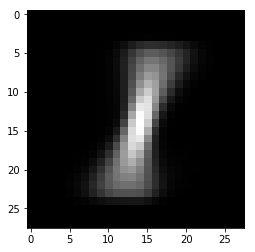

label of image is --> 2


In [67]:
len_set = len(mnist_training_images[mnist_training_labels==1])
asd = np.mean(mnist_training_images[mnist_training_labels==1],axis=0)
im = np.reshape(asd, (28,28))
plt.imshow(im, cmap='gray')
plt.show()
print('label of image is --> '+str(mnist_testing_labels[1]))

In [70]:
distances = [np.linalg.norm(asd-e) for e in mnist_training_images]

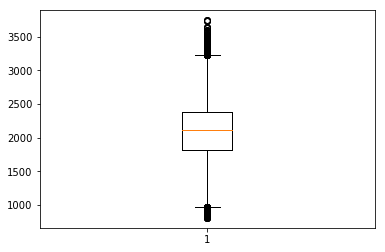

In [64]:
import matplotlib.pyplot as plt
plt.boxplot([np.linalg.norm(asd-e) for e in mnist_training_images])
plt.show()

In [99]:



def gaussian(x, m, v):
    return 1 / np.sqrt(2 * np.pi * v) * np.exp(-(x - m)**2 / (2 * v))

var = np.std(distances,axis=0, ddof=1)
mn = np.mean(distances,axis=0)

asd = np.array([1 - gaussian(e,mn,var)/0.018366605621986522 for e in distances])
len(asd[asd<=0.8])/len(distances)

0.07325

In [142]:
class BLR_mod(BLR):
    def __init__(self, classes, training_data,
                 training_labels, test_data,test_labels, sigma, binary=True):
        self.original_classes = classes
        self.classes = np.eye(len(classes)) if binary == True else classes
        self.training_data = training_data
        self.training_labels = training_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.mu = []
        self.sigma2 = []
        self.top_gaussian = []
        self.class_mean = []
        self.sigma = sigma   
        self.binary = binary
        
    def gaussian(self, x, m, v):
        return 1 / np.sqrt(2 * np.pi * v) * np.exp(-(x - m)**2 / (2 * v))
    
    def mean_and_var(self):
        for c in self.original_classes:
            class_mean = np.mean(self.training_data[self.training_labels == c],axis=0)
            distances = [np.linalg.norm(class_mean-e) for e in self.training_data[self.training_labels == c]]
            # var of the distances
            var = np.std(distances,axis=0, ddof=1)
            # mean of the distances
            mn = np.mean(distances,axis=0)
            self.class_mean.append(class_mean)
            self.top_gaussian.append(self.gaussian(mn,mn,var))
            self.mu.append(mn)
            self.sigma2.append(var)
        self.mu = np.array(self.mu)
        self.sigma2 = np.array(self.sigma2)

    
    def labels(self):
        labels = np.zeros((len(self.training_labels),10))
        i = 0
        for c,e in zip(self.training_labels,self.training_data):
            dist = np.linalg.norm(self.class_mean[c]-e)
            ratio = 1 - gaussian(dist,self.mu[c],self.sigma2[c])/self.top_gaussian[c]
            labels[i] = self.classes[c]
            if ratio > 0.8:
                for cls in self.original_classes:
                    if cls != c:
                        dist = np.linalg.norm(self.class_mean[cls]-e)
                        labels[i][cls] = gaussian(dist,self.mu[c],self.sigma2[c])/self.top_gaussian[cls]
            i += 1
        self.training_labels = labels
        
            
            

In [151]:
import time
classes = [0,1,2,3,4,5,6,7,8,9]
c = BLR_mod(classes,mnist_training_images,mnist_training_labels,mnist_testing_images,mnist_testing_labels,0.05)
c.mean_and_var()
c.labels()
c.adjust_data(2)
c.generate_w()
# c.save_model('model_k2_True_s05_mod')

In [152]:
c.make_prediction()
c.accuracy()

(8846, 1154)